In [1]:
data_dir = "../data/"
VOC2012_path = data_dir + "VOCdevkit/"
tracker_path = "../Tracking_SSD_ReID/"
ssd_weights_path = data_dir + "ssd_weights_epoch_0380.h5"
checkpoint_filepath = data_dir + "weights_vgg16styletransfer/"
final_model_path = data_dir + "weights_vgg16styletransfer_final/"

In [2]:
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import imageio
from tqdm import tqdm
import cv2

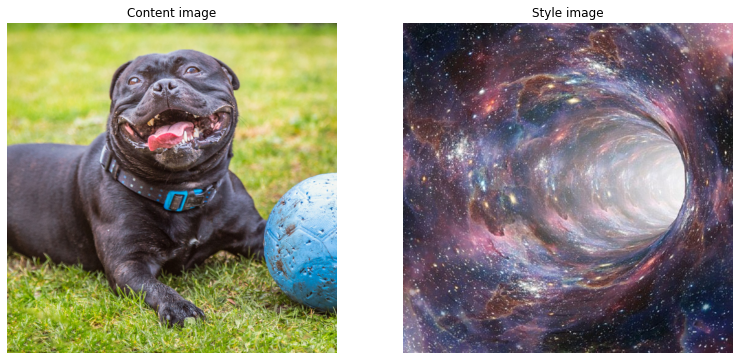

In [3]:
content_image = Image.open("imgs/content.jpg")
content_image_np = np.array(content_image)

style_image = Image.open("imgs/style.jpg")
style_image_np = np.array(style_image)

fig, axs = plt.subplots(1, 2, figsize=(13, 25), facecolor='w', edgecolor='k')

axs[0].axis('off')
axs[0].set_title("Content image")
axs[0].imshow(content_image_np)

axs[1].axis('off')
axs[1].set_title("Style image")
axs[1].imshow(style_image_np)

content_image = cv2.resize(content_image_np, (300, 300),
                           interpolation=cv2.INTER_NEAREST)
content_image = tf.expand_dims(tf.convert_to_tensor(content_image, dtype=tf.float32), 0)

style_image = cv2.resize(style_image_np, (300, 300),
                           interpolation=cv2.INTER_NEAREST)
style_image = tf.expand_dims(tf.convert_to_tensor(style_image, dtype=tf.float32), 0)

In [4]:
from models.VGG16StyleTransfer import VGG16StyleTransfer
model = VGG16StyleTransfer(
    tracker_ssd_path = tracker_path, 
    ssd_weights_path = ssd_weights_path)

In [5]:
images = model(style_image, content_image, tf.keras.optimizers.Adam(learning_rate=10), epochs=50)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.39it/s]


In [8]:
adam = tf.keras.optimizers.Adam(learning_rate=10)

images = training(style_image, content_image, adam, epochs=50)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.50it/s]


In [6]:
out_gif = "imgs/training2.gif"
images[0].save(out_gif, format='GIF',
               append_images=images[1:],
               save_all=True, loop=0)
gif = imageio.mimread(out_gif)
imageio.mimsave(out_gif, gif, fps=2)

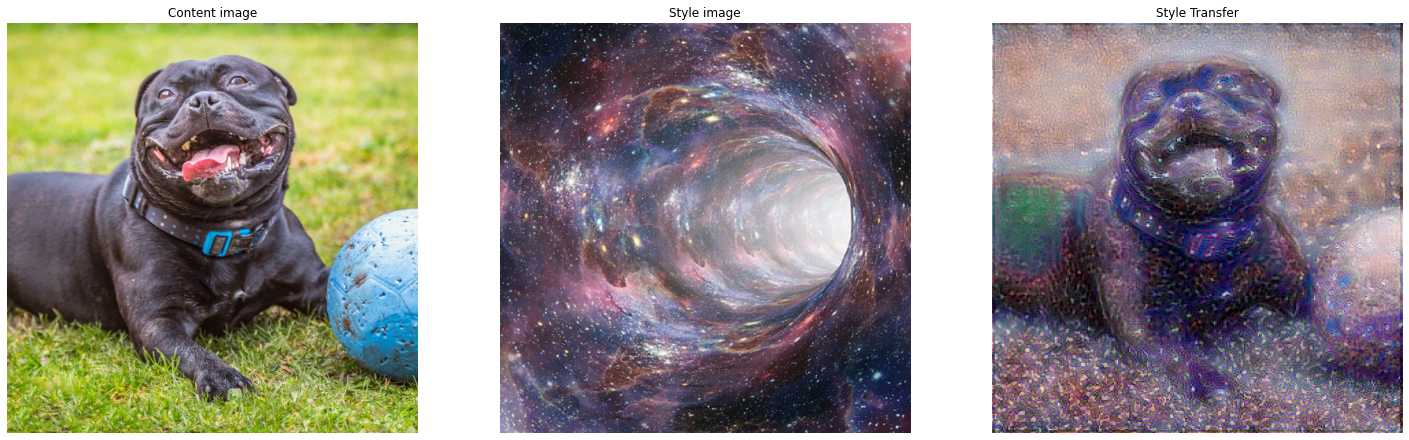

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(25, 40), facecolor='w', edgecolor='k')

axs[0].axis('off')
axs[0].set_title("Content image")
axs[0].imshow(content_image_np)

axs[1].axis('off')
axs[1].set_title("Style image")
axs[1].imshow(style_image_np)

axs[2].axis('off')
axs[2].set_title("Style Transfer")
axs[2].imshow(images[50])

In [38]:
fig.savefig('imgs/style_transfer.png', dpi=50, bbox_inches = 'tight', pad_inches = 1)